In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy import linalg as LA
from PIL import Image
import matplotlib.pyplot as plt

# https://youtu.be/SaEmG4wcFfg?si=DA3WVz-m5vhQSWuy

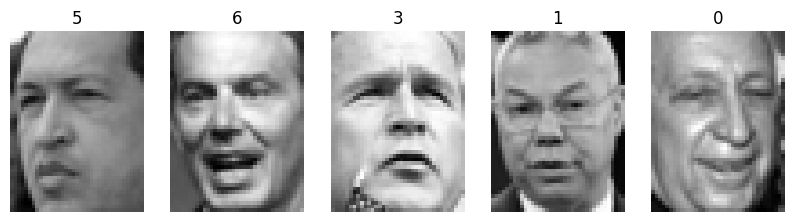

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Show the first 5 samples from the dataset
fig, axs = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    axs[i].imshow(lfw_people.images[i], cmap='gray')
    axs[i].set_title(lfw_people.target[i])
    axs[i].axis('off')
plt.show()

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [5]:

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_stacked = np.column_stack((X_train_normalized))
X_train_stacked.shape #N^2 * M

(1850, 966)

In [6]:
cov_matrix = np.cov(X_train_stacked) #cov= A*A^T 
print(cov_matrix)

[[ 1.00103628e+00  9.33115905e-01  7.78384382e-01 ...  3.05566064e-03
  -1.26172584e-02 -2.63080423e-02]
 [ 9.33115905e-01  1.00103627e+00  8.98681257e-01 ...  1.39497783e-02
   2.47042400e-03 -1.70691009e-02]
 [ 7.78384382e-01  8.98681257e-01  1.00103625e+00 ...  7.85702075e-03
  -7.09239945e-04 -2.43257895e-02]
 ...
 [ 3.05566064e-03  1.39497783e-02  7.85702075e-03 ...  1.00103628e+00
   8.98058875e-01  7.15818695e-01]
 [-1.26172584e-02  2.47042400e-03 -7.09239945e-04 ...  8.98058875e-01
   1.00103629e+00  9.10392628e-01]
 [-2.63080423e-02 -1.70691009e-02 -2.43257895e-02 ...  7.15818695e-01
   9.10392628e-01  1.00103629e+00]]


In [7]:
cov_matrix.shape
#### N^2 * N^2


(1850, 1850)

In [8]:
# now to find k significant eigenfaces (dimensionality reduction) k<=M (M=number of images)
# cov = A^T * A   M*M

cov_matrix2= np.cov(np.transpose(X_train_stacked))
cov_matrix2.shape

(966, 966)

In [9]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix2)
# Sort the eigenvalues in descending order and get the indices

idx = np.argsort(eigenvalues)[::-1]

# Select the top k eigenvalues and their corresponding eigenvectors
k = 100  # replace with your desired number of components
top_k_eigenvalues = eigenvalues[idx[:k]]
top_k_eigenvectors = eigenvectors[:, idx[:k]]

# Transform the original dataset by projecting it onto the top k eigenfaces
X_train_transformed = np.dot(X_train_stacked, top_k_eigenvectors)

In [10]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix2)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]
####projecting the original dataset onto the top k eigenfaces
eigenconverted= np.dot(X_train_stacked, eigenvectors)

In [11]:
# Normalizing the eigenvectors (making them unit norm)
eigenfaces = eigenconverted.T/ np.sqrt((eigenconverted.T ** 2).sum(axis=1, keepdims=True))
eigenfaces.shape

(966, 1850)

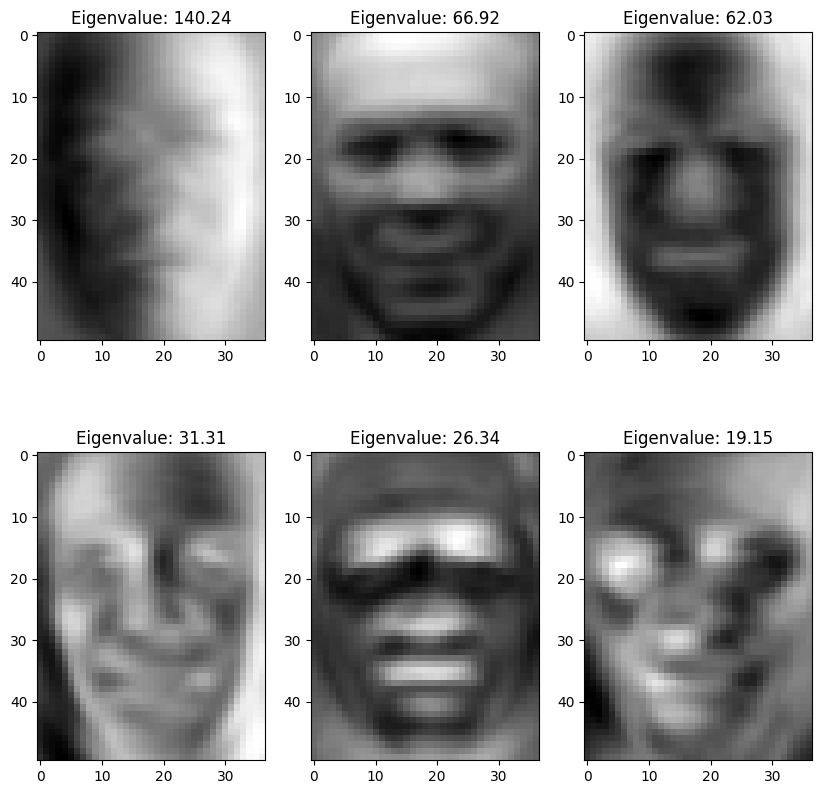

In [12]:


_, axs = plt.subplots(2, 3, figsize=(10, 10))
axs = axs.flatten()
for i, (img, ax) in enumerate(zip(eigenfaces, axs)):
    ax.set_title(f"Eigenvalue: {np.round(eigenvalues[i], 2)}")
    ax.imshow(img.reshape(h, w), cmap="gray")
plt.show()

In [ ]:
###### GITHUB COPILOT ######

# Compute PCA (eigenfaces) on the face dataset without specifying the number of components
pca = PCA(svd_solver='randomized', whiten=True).fit(X_train)

# Calculate the cumulative sum of explained variances
explained_variances = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain a certain percentage of the variance
percentages = [0.10, 0.15, 0.60]
n_components = [np.argmax(explained_variances >= p) + 1 for p in percentages]

# Select the top k eigenfaces, project the training set onto the eigenfaces, and reconstruct the images
images_reconstructed = []
for n in n_components:
    pca = PCA(n_components=n, svd_solver='randomized', whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_reconstructed = pca.inverse_transform(X_train_pca)
    images_reconstructed.append(X_reconstructed)

# Plot the cumulative explained variances
plt.figure()
plt.plot(explained_variances)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Components vs Variance')
plt.grid(True)
plt.show()

# Plot the original images and the reconstructed images
fig, ax = plt.subplots(len(n_components), 2, figsize=(8, 4 * len(n_components)))

for i, images in enumerate(images_reconstructed):
    ax[i, 0].imshow(X_train[0].reshape((h, w)), cmap=plt.cm.gray)
    ax[i, 0].set_title('Original Image')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(images[0].reshape((h, w)), cmap=plt.cm.gray)
    ax[i, 1].set_title(f'Reconstructed Image\n{n_components[i]} Components')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()